In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm,colors

In [2]:
from model import Model
from model import convertToOneHot, DataSet_meta
import optuna

In [3]:
from sklearn.metrics import mean_squared_error

## Data Generation

#### E5:
$$
y = \begin{cases}
    x_1 \times x_2 + 2x_{21} & \text{if } x_{21} = -1 \\ 
    x_2 \times x_3 + 2x_{21} & \text{if } x_{21} = 0  \\
    x_3 \times x_4 + 2x_{21} & \text{if } x_{21} = 1  \\
\end{cases}
$$

In [4]:
N_train = 1500
N_valid=300
N_test = 300
D=20

In [5]:
np.random.seed(42)

In [6]:
group_size=int(N_train/3)
X_train = np.sign(np.random.normal(0,1,(N_train,D)))
X_train = np.concatenate((X_train,
                         np.concatenate(([-1]*group_size,[0]*group_size,[1]*group_size)).reshape(-1,1)),axis=1)
Y_train = np.concatenate((X_train[:group_size,0]*X_train[:group_size,1]+2*X_train[:group_size,-1],
                          X_train[group_size:(group_size*2),1]*X_train[group_size:(group_size*2),2]+2*X_train[group_size:(group_size*2),-1],
                          X_train[(group_size*2):(group_size*3),2]*X_train[(group_size*2):(group_size*3),3]+2*X_train[(group_size*2):(group_size*3),-1],
                         ),axis=0)

In [7]:
group_size=int(N_valid/3)
X_valid = np.sign(np.random.normal(0,1,(N_valid,D)))
X_valid = np.concatenate((X_valid,
                         np.concatenate(([-1]*group_size,[0]*group_size,[1]*group_size)).reshape(-1,1)),axis=1)
Y_valid = np.concatenate((X_valid[:group_size,0]*X_valid[:group_size,1]+2*X_valid[:group_size,-1],
                          X_valid[group_size:(group_size*2),1]*X_valid[group_size:(group_size*2),2]+2*X_valid[group_size:(group_size*2),-1],
                          X_valid[(group_size*2):(group_size*3),2]*X_valid[(group_size*2):(group_size*3),3]+2*X_valid[(group_size*2):(group_size*3),-1],
                         ),axis=0)

In [8]:
group_size=int(N_test/3)
X_test = np.sign(np.random.normal(0,1,(N_test,D)))
X_test = np.concatenate((X_test,
                         np.concatenate(([-1]*group_size,[0]*group_size,[1]*group_size)).reshape(-1,1)),axis=1)
Y_test = np.concatenate((X_test[:group_size,0]*X_test[:group_size,1]+2*X_test[:group_size,-1],
                          X_test[group_size:(group_size*2),1]*X_test[group_size:(group_size*2),2]+2*X_test[group_size:(group_size*2),-1],
                          X_test[(group_size*2):(group_size*3),2]*X_test[(group_size*2):(group_size*3),3]+2*X_test[(group_size*2):(group_size*3),-1],
                         ),axis=0)

In [9]:
np.random.seed(42)
train_sample_indices = np.arange(N_train)
np.random.shuffle(train_sample_indices)

X_train = X_train[train_sample_indices,:]
Y_train = Y_train[train_sample_indices]

In [10]:
valid_sample_indices = np.arange(N_valid)
np.random.shuffle(valid_sample_indices)

X_valid = X_valid[valid_sample_indices,:]
Y_valid = Y_valid[valid_sample_indices]

In [11]:
test_sample_indices = np.arange(N_test)
np.random.shuffle(test_sample_indices)

X_test = X_test[test_sample_indices,:]
Y_test = Y_test[test_sample_indices]

## Run LSPIN

In [12]:
dataset = DataSet_meta(**{'_data':X_train, '_labels':Y_train.reshape(-1,1), '_meta':Y_train.reshape(-1,1),
                '_valid_data':X_valid, '_valid_labels':Y_valid.reshape(-1,1),'_valid_meta': Y_valid.reshape(-1,1),
                '_test_data':X_test, '_test_labels':Y_test.reshape(-1,1), '_test_meta':Y_test.reshape(-1,1),})

In [13]:
model_params = {'input_node': X_train.shape[1],
 'hidden_layers_node': [500, 100, 1],
 'output_node': 1,
 'feature_selection': True,
 'gating_net_hidden_layers_node': [100],
 'display_step': 1000,
 'activation_gating': 'tanh',
 'activation_pred': 'l_relu',
 'lam': 1}

In [14]:
training_params = {
    'batch_size':X_train.shape[0]
}

In [15]:
# objective function for optuna hyper-parameter optimization
def lstg_objective(trial):  
    
    global model
            
    training_params['lr'] = trial.suggest_loguniform('learning_rate',0.01,0.1) 
    training_params["num_epoch"] = trial.suggest_categorical('num_epoch', [2000,3000,5000,7000])

    model = Model(**model_params)
    train_acces, train_losses, val_acces, val_losses = model.train(dataset=dataset,
                                                               **training_params
                                                              )
    
    alpha_mat_valid=model.get_prob_alpha(X_valid)
    print("In trial:---------------------")
    print("union feat: {}".format(sum(np.sum(alpha_mat_valid > 0,axis=0)>0)))
    print("median feat: {}".format(np.median(np.sum(alpha_mat_valid > 0,axis=1))))
       
    loss= val_losses[-1]
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [17]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(lstg_objective, n_trials=20, callbacks=[callback])

[I 2022-01-27 02:44:33,575] A new study created in memory with name: no-name-7db6f61c-f8b2-484a-a551-886ce68edf8b


num_samples : 1500
Epoch: 1000 train loss=0.763489604 valid loss= 0.664828300
Epoch: 2000 train loss=0.413426101 valid loss= 0.347265512
Epoch: 3000 train loss=0.356250465 valid loss= 0.305183172
Epoch: 4000 train loss=0.348233759 valid loss= 0.299743474
Epoch: 5000 train loss=0.331610113 valid loss= 0.292882681
Epoch: 6000 train loss=0.322337300 valid loss= 0.287250578


[I 2022-01-27 02:45:36,100] Trial 0 finished with value: 0.28526127338409424 and parameters: {'learning_rate': 0.014142394653685757, 'num_epoch': 7000}. Best is trial 0 with value: 0.28526127338409424.


Epoch: 7000 train loss=0.313670546 valid loss= 0.285261273
Optimization Finished!
test loss: 0.28539472818374634, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.331825525 valid loss= 0.293193966
Epoch: 2000 train loss=0.303772449 valid loss= 0.283340156
Epoch: 3000 train loss=0.307156891 valid loss= 0.286126226
Epoch: 4000 train loss=0.311347246 valid loss= 0.281119674
Epoch: 5000 train loss=0.292486906 valid loss= 0.280392587
Epoch: 6000 train loss=0.291246593 valid loss= 0.282726020


[I 2022-01-27 02:46:38,789] Trial 1 finished with value: 0.28080520033836365 and parameters: {'learning_rate': 0.07924635860833862, 'num_epoch': 7000}. Best is trial 1 with value: 0.28080520033836365.


Epoch: 7000 train loss=0.294735670 valid loss= 0.280805200
Optimization Finished!
test loss: 0.28074586391448975, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.462686181 valid loss= 0.417351454


[I 2022-01-27 02:46:58,030] Trial 2 finished with value: 0.33124247193336487 and parameters: {'learning_rate': 0.03981334133839327, 'num_epoch': 2000}. Best is trial 1 with value: 0.28080520033836365.


Epoch: 2000 train loss=0.374475539 valid loss= 0.331242472
Optimization Finished!
test loss: 0.3266412019729614, test acc: 1.0
In trial:---------------------
union feat: 14
median feat: 4.0
num_samples : 1500
Epoch: 1000 train loss=0.789332032 valid loss= 0.694122672
Epoch: 2000 train loss=0.430617213 valid loss= 0.363718778
Epoch: 3000 train loss=0.368334681 valid loss= 0.318091989
Epoch: 4000 train loss=0.352876961 valid loss= 0.307152361
Epoch: 5000 train loss=0.333127379 valid loss= 0.300463617
Epoch: 6000 train loss=0.344740093 valid loss= 0.306336910


[I 2022-01-27 02:48:00,819] Trial 3 finished with value: 0.2979745864868164 and parameters: {'learning_rate': 0.0161857880049561, 'num_epoch': 7000}. Best is trial 1 with value: 0.28080520033836365.


Epoch: 7000 train loss=0.327946246 valid loss= 0.297974586
Optimization Finished!
test loss: 0.2979092001914978, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.343280166 valid loss= 0.308035254
Epoch: 2000 train loss=0.318222255 valid loss= 0.284338146
Epoch: 3000 train loss=0.306477845 valid loss= 0.284354895
Epoch: 4000 train loss=0.299026787 valid loss= 0.282553673


[I 2022-01-27 02:48:46,264] Trial 4 finished with value: 0.28076401352882385 and parameters: {'learning_rate': 0.06445201217297805, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.295667529 valid loss= 0.280764014
Optimization Finished!
test loss: 0.2807355225086212, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.422218770 valid loss= 0.381009161
Epoch: 2000 train loss=0.337540746 valid loss= 0.293814182
Epoch: 3000 train loss=0.319016814 valid loss= 0.288436592
Epoch: 4000 train loss=0.310676754 valid loss= 0.284166127
Epoch: 5000 train loss=0.307676524 valid loss= 0.285369903
Epoch: 6000 train loss=0.303480744 valid loss= 0.285188496


[I 2022-01-27 02:49:49,460] Trial 5 finished with value: 0.282027930021286 and parameters: {'learning_rate': 0.026744584554884415, 'num_epoch': 7000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 7000 train loss=0.297481805 valid loss= 0.282027930
Optimization Finished!
test loss: 0.2820155620574951, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.354428142 valid loss= 0.300112486
Epoch: 2000 train loss=0.315219760 valid loss= 0.285317451
Epoch: 3000 train loss=0.317813963 valid loss= 0.292607516
Epoch: 4000 train loss=0.306395888 valid loss= 0.285342276
Epoch: 5000 train loss=0.299309045 valid loss= 0.283370614
Epoch: 6000 train loss=0.298734784 valid loss= 0.283085078


[I 2022-01-27 02:50:52,461] Trial 6 finished with value: 0.28137049078941345 and parameters: {'learning_rate': 0.05278362971590137, 'num_epoch': 7000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 7000 train loss=0.293508053 valid loss= 0.281370491
Optimization Finished!
test loss: 0.28141891956329346, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.331458867 valid loss= 0.292968154
Epoch: 2000 train loss=0.309948564 valid loss= 0.289608836
Epoch: 3000 train loss=0.307645470 valid loss= 0.286528051
Epoch: 4000 train loss=0.315821171 valid loss= 0.298227996


[I 2022-01-27 02:51:37,836] Trial 7 finished with value: 0.2825685441493988 and parameters: {'learning_rate': 0.08903952682244844, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.295552522 valid loss= 0.282568544
Optimization Finished!
test loss: 0.2827301025390625, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.409633815 valid loss= 0.330396533
Epoch: 2000 train loss=0.337618738 valid loss= 0.293059766
Epoch: 3000 train loss=0.332377046 valid loss= 0.285082012
Epoch: 4000 train loss=0.310496271 valid loss= 0.285313934
Epoch: 5000 train loss=0.319207907 valid loss= 0.283061475
Epoch: 6000 train loss=0.309553444 valid loss= 0.283518314


[I 2022-01-27 02:52:40,731] Trial 8 finished with value: 0.2817590534687042 and parameters: {'learning_rate': 0.03057515102298176, 'num_epoch': 7000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 7000 train loss=0.300420105 valid loss= 0.281759053
Optimization Finished!
test loss: 0.2817884683609009, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.353857726 valid loss= 0.316712826


[I 2022-01-27 02:53:00,488] Trial 9 finished with value: 0.28791099786758423 and parameters: {'learning_rate': 0.041261473185627506, 'num_epoch': 2000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 2000 train loss=0.323896021 valid loss= 0.287910998
Optimization Finished!
test loss: 0.2879062592983246, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.340813130 valid loss= 0.299750268
Epoch: 2000 train loss=0.320382595 valid loss= 0.289170235


[I 2022-01-27 02:53:28,765] Trial 10 finished with value: 0.28221696615219116 and parameters: {'learning_rate': 0.06897033337286865, 'num_epoch': 3000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 3000 train loss=0.305382490 valid loss= 0.282216966
Optimization Finished!
test loss: 0.28200313448905945, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.324670851 valid loss= 0.292677790
Epoch: 2000 train loss=0.305937678 valid loss= 0.285808653
Epoch: 3000 train loss=0.296203911 valid loss= 0.280796051
Epoch: 4000 train loss=0.292654753 valid loss= 0.281079650


[I 2022-01-27 02:54:15,070] Trial 11 finished with value: 0.2809104323387146 and parameters: {'learning_rate': 0.09453272537070384, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.292513281 valid loss= 0.280910432
Optimization Finished!
test loss: 0.28066250681877136, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.339726359 valid loss= 0.296134770
Epoch: 2000 train loss=0.314547747 valid loss= 0.285711557
Epoch: 3000 train loss=0.310898751 valid loss= 0.287513345
Epoch: 4000 train loss=0.302660465 valid loss= 0.286396623


[I 2022-01-27 02:55:00,940] Trial 12 finished with value: 0.28385627269744873 and parameters: {'learning_rate': 0.0627608492688713, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.298814744 valid loss= 0.283856273
Optimization Finished!
test loss: 0.2837928235530853, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.462426960 valid loss= 0.422205448
Epoch: 2000 train loss=0.347982645 valid loss= 0.306759387
Epoch: 3000 train loss=0.329551429 valid loss= 0.291186363
Epoch: 4000 train loss=0.318383694 valid loss= 0.287736356


[I 2022-01-27 02:55:46,920] Trial 13 finished with value: 0.2876785397529602 and parameters: {'learning_rate': 0.021961032282362947, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.320323467 valid loss= 0.287678540
Optimization Finished!
test loss: 0.2872154712677002, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.346327782 valid loss= 0.309597760
Epoch: 2000 train loss=0.317032337 valid loss= 0.286652833


[I 2022-01-27 02:56:14,908] Trial 14 finished with value: 0.2832625210285187 and parameters: {'learning_rate': 0.050859236377150834, 'num_epoch': 3000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 3000 train loss=0.312844515 valid loss= 0.283262521
Optimization Finished!
test loss: 0.28319159150123596, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.381032616 valid loss= 0.309761494
Epoch: 2000 train loss=0.327998579 valid loss= 0.290919721
Epoch: 3000 train loss=0.324188143 valid loss= 0.286131173
Epoch: 4000 train loss=0.309011161 valid loss= 0.284014493


[I 2022-01-27 02:57:00,681] Trial 15 finished with value: 0.28334370255470276 and parameters: {'learning_rate': 0.07473696261165531, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.307816595 valid loss= 0.283343703
Optimization Finished!
test loss: 0.2845681607723236, test acc: 1.0
In trial:---------------------
union feat: 6
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.993694186 valid loss= 0.928655744


[I 2022-01-27 02:57:19,730] Trial 16 finished with value: 0.3910070061683655 and parameters: {'learning_rate': 0.010974935035457312, 'num_epoch': 2000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 2000 train loss=0.484966040 valid loss= 0.391007006
Optimization Finished!
test loss: 0.38740190863609314, test acc: 1.0
In trial:---------------------
union feat: 16
median feat: 4.0
num_samples : 1500
Epoch: 1000 train loss=0.346441358 valid loss= 0.311035544
Epoch: 2000 train loss=0.312015027 valid loss= 0.286684811


[I 2022-01-27 02:57:48,257] Trial 17 finished with value: 0.29191190004348755 and parameters: {'learning_rate': 0.041840884222509346, 'num_epoch': 3000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 3000 train loss=0.318258792 valid loss= 0.291911900
Optimization Finished!
test loss: 0.2916521430015564, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.343447179 valid loss= 0.302992523
Epoch: 2000 train loss=0.320013911 valid loss= 0.287334561
Epoch: 3000 train loss=0.301980048 valid loss= 0.283091813
Epoch: 4000 train loss=0.296925694 valid loss= 0.281536281
Epoch: 5000 train loss=0.298510522 valid loss= 0.283499449
Epoch: 6000 train loss=0.300892264 valid loss= 0.283836067


[I 2022-01-27 02:58:51,889] Trial 18 finished with value: 0.28263986110687256 and parameters: {'learning_rate': 0.05901848899994408, 'num_epoch': 7000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 7000 train loss=0.292461395 valid loss= 0.282639861
Optimization Finished!
test loss: 0.28321486711502075, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0
num_samples : 1500
Epoch: 1000 train loss=0.331579715 valid loss= 0.290780783
Epoch: 2000 train loss=0.307942510 valid loss= 0.284310639
Epoch: 3000 train loss=0.309303969 valid loss= 0.285773903
Epoch: 4000 train loss=0.299213290 valid loss= 0.284449160


[I 2022-01-27 02:59:37,684] Trial 19 finished with value: 0.28695622086524963 and parameters: {'learning_rate': 0.09756068728569076, 'num_epoch': 5000}. Best is trial 4 with value: 0.28076401352882385.


Epoch: 5000 train loss=0.302873313 valid loss= 0.286956221
Optimization Finished!
test loss: 0.28644827008247375, test acc: 1.0
In trial:---------------------
union feat: 5
median feat: 3.0


In [18]:
Y_test_pred = best_model.test(X_test)[0].reshape(-1) 
print("Mean Squared Error on the test: {:.5f}".format(np.mean((Y_test - Y_test_pred)**2)))

Mean Squared Error on the test: 0.00086


## Visualizing the gate matrix

In [19]:
gate_matrix_test = best_model.get_prob_alpha(X_test)

In [20]:
# compare to ground truth
g_test = np.zeros((X_test.shape[0],X_test.shape[1]))
for i in range(g_test.shape[0]):
    if X_test[i,-1] == -1:
        g_test[i,0] = 1
        g_test[i,1] = 1
    elif X_test[i,-1] == 0:
        g_test[i,1] = 1
        g_test[i,2] = 1
    elif X_test[i,-1] == 1:
        g_test[i,2] = 1
        g_test[i,3] = 1
g_test[:,-1] = 1

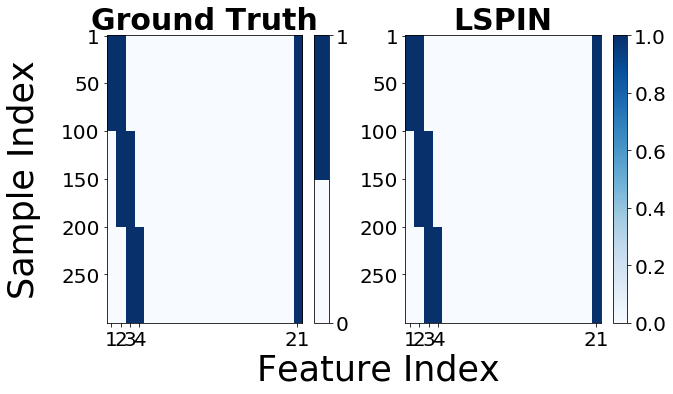

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True,sharey=False,figsize=(10,6))



cmap = cm.Blues 
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig.add_subplot(111, frameon=False)

title_size = 30

xlabel_size = 35
ylabel_size = 35

xtick_size = 20
ytick_size = 20
bar_label_size = 20

matplotlib.rc('xtick', labelsize=20) 


# Test
y_axis_order = np.argsort(X_test[:,-1])

im5 = axes[0].imshow(g_test[y_axis_order,:],aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold")
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size,labelpad=20)
axes[0].set_xticks([0,1,2,3,20])
axes[0].set_xticklabels([1,2,3,4,21])
axes[0].set_yticks([0,49,99,149,199,249])
axes[0].set_yticklabels([1,50,100,150,200,250],fontsize=ytick_size)

im7 = axes[1].imshow(gate_matrix_test[y_axis_order,:],aspect='auto',cmap=cmap)
axes[1].set_title("LSPIN",fontsize=title_size,fontweight="bold")
axes[1].set_yticks([0,49,99,149,199,249])
axes[1].set_yticklabels([1,50,100,150,200,250],fontsize=ytick_size)

cbar = fig.colorbar(im5,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)

cbar = fig.colorbar(im7,ax=axes[1],cmap=cmap)
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index",fontsize=xlabel_size)
#plt.xticks(list(range(1,12)))


plt.tight_layout()
plt.show()